<a href="https://colab.research.google.com/github/abhaykekare/Python/blob/main/Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Portfolio Optimization (Mean–Variance + Sharpe Maximization)

In [ ]:
# Overview, This project implements mean-variance portfolio optimization and Sharpe (tangency) maximization in Python.
# It downloads historical price data, estimates expected returns and covariances, builds the efficient frontier, finds tangency portfolios, and performs a walk-forward backtest comparing to benchmarks.

In [ ]:
# importing required python libraries
import numpy as np                  # Numerical arrays, linear algebra operations
import pandas as pd                # Data manipulation, time series handling
import matplotlib.pyplot as plt    # Plotting library
import yfinance as yf              # To download financial price data
from scipy.optimize import minimize  # Optimization function for portfolio optimization


In [ ]:
# helping functions

def get_data(tickers, start="2019-01-01", end=None): #extracting data from 2019 to till date
    """
    Download adjusted price data for selected tickers.
    auto_adjust=True ensures dividends/splits are already handled.
    """
    prices = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)
    return prices['Close']          # We use the adjusted closing price


def returns_from_prices(prices, period='monthly'):
    """
    Convert price series into returns series.
    period = 'daily' or 'monthly' or 'yearly'
    """
    if period == 'daily':
        rets = prices.pct_change().dropna()      # Daily % returns, rets is returns here
    elif period == 'monthly':
        rets = prices.resample('M').last().pct_change().dropna()    # Monthly % returns
    else:
        raise ValueError("period must be 'daily' or 'monthly'")
    return rets


def portfolio_return(weights, mean_returns):
    """
    Portfolio expected return = sum(weights * mean_returns)
    """
    return np.dot(weights, mean_returns)


def portfolio_vol(weights, cov_matrix):
    """
    Portfolio volatility = sqrt(w^T Σ w)
    """
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))


def neg_sharpe(weights, mean_returns, cov_matrix, rf=0.0):
    """
    Negative Sharpe ratio (because optimizer minimizes).
    Sharpe = (PortfolioReturn - RiskFree) / PortfolioVol
    """
    ret = portfolio_return(weights, mean_returns)
    vol = portfolio_vol(weights, cov_matrix)
    return -(ret - rf) / vol        # Negative because minimize() searches for minimum

def minimize_vol_for_target_return(target_return, mean_returns, cov_matrix, bounds, initial_guess):
    """
    Solve optimization for minimum variance portfolio given a target expected return.
    Constraints:
        1. sum(weights) = 1
        2. portfolio return = target return
    """

    n = len(mean_returns)    # Number of assets

    # Define constraints for optimizer
    constraints = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},                         # weights sum to 1
        {'type': 'eq', 'fun': lambda w: portfolio_return(w, mean_returns) - target_return},  # target return
    )

    # Optimization call
    result = minimize(
        lambda w: portfolio_vol(w, cov_matrix),  # objective: minimize portfolio volatility
        x0=initial_guess,                        # initial guess for weights
        bounds=bounds,                           # weight bounds (0–1)
        constraints=constraints
    )

    return result

# example workflow parameters

TICKERS = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA", "JNJ", "JPM", "NVDA"]   # List of assets
start_date = "2019-01-01"      # Start date for price data
period = 'monthly'             # Use monthly returns (more stable estimates)
rf = 0.01 / 12                 # Monthly risk-free rate (approx 1% per year)


# fetch data

prices = get_data(TICKERS, start=start_date)  # Download price data
rets = returns_from_prices(prices, period=period)  # Convert prices to returns

mean_returns = rets.mean()    # Expected return = sample mean of returns
cov_matrix = rets.cov()       # Covariance matrix of returns

n = len(TICKERS)                               # Number of assets
bounds = tuple((0, 1) for _ in range(n))        # Each weight between 0 and 1 (no shorting)
init_guess = np.repeat(1/n, n)                  # Initial guess = equal weights


/tmp/ipython-input-1855952166.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rets = prices.resample('M').last().pct_change().dropna()    # Monthly % returns


In [ ]:
# compute efficient frontier

# Range of target returns (from low to high)
target_returns = np.linspace(mean_returns.min()*0.8,
                             mean_returns.max()*1.2,
                             50)

efficient_weights = []   # Store optimal weights for each point on the frontier
efficient_vols = []      # Store volatility values
failed = 0               # Track failed optimizer attempts


In [ ]:
# Loop over each target return
for tr in target_returns:
    res = minimize_vol_for_target_return(
        tr,
        mean_returns.values,
        cov_matrix.values,
        bounds,
        init_guess
    )

    if res.success:
        w = res.x
        efficient_weights.append(w)
        efficient_vols.append(portfolio_vol(w, cov_matrix.values))
    else:
        failed += 1

In [ ]:
# Convert lists into arrays
efficient_returns = target_returns[:len(efficient_vols)]
efficient_vols = np.array(efficient_vols)

In [ ]:
# find minimum variance portfolio from the frontier

min_var_idx = np.argmin(efficient_vols)           # Index of lowest-vol point
min_var_weights = efficient_weights[min_var_idx]  # Corresponding weights
min_var_return = efficient_returns[min_var_idx]   # Expected return of min variance
min_var_vol = efficient_vols[min_var_idx]         # Volatility of min variance

In [ ]:
# find tangency portfolio (max Sharpe)

# Constraint: weights must sum to 1
cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

In [ ]:
# Run optimization: minimize negative Sharpe
res_tan = minimize(
    neg_sharpe,
    x0=init_guess,
    args=(mean_returns.values, cov_matrix.values, rf),
    bounds=bounds,
    constraints=cons
)

In [ ]:
tan_weights = res_tan.x                           # Tangency portfolio weights
tan_return = portfolio_return(tan_weights, mean_returns.values)
tan_vol = portfolio_vol(tan_weights, cov_matrix.values)
tan_sharpe = (tan_return - rf) / tan_vol          # Sharpe ratio

/tmp/ipython-input-1387984284.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(t, (np.sqrt(cov_matrix.values[i,i]), mean_returns[i]))


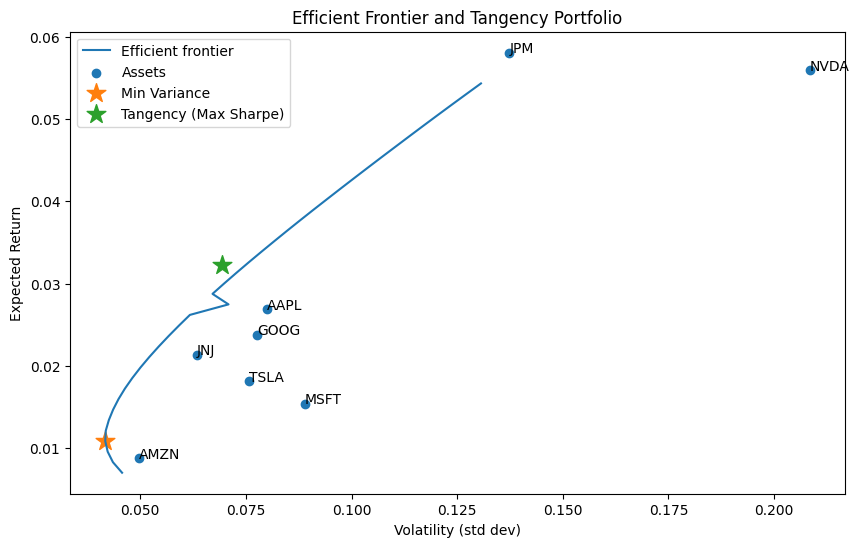

In [ ]:
# Visualization: Efficient Frontier

plt.figure(figsize=(10,6))

# Plot frontier curve
plt.plot(efficient_vols, efficient_returns, label='Efficient frontier')

# Plot individual assets
plt.scatter(np.sqrt(np.diag(cov_matrix)), mean_returns, marker='o', label='Assets')

# Label each asset
for i, t in enumerate(TICKERS):
    plt.annotate(t, (np.sqrt(cov_matrix.values[i,i]), mean_returns[i]))

# Mark special points
plt.scatter(min_var_vol, min_var_return, marker='*', s=200, label='Min Variance')
plt.scatter(tan_vol, tan_return, marker='*', s=200, label='Tangency (Max Sharpe)')

plt.xlabel('Volatility (std dev)')
plt.ylabel('Expected Return')
plt.legend()
plt.title('Efficient Frontier and Tangency Portfolio')
plt.show()



In [ ]:
#  Display weights in table format

weights_df = pd.DataFrame({
    'min_variance': min_var_weights,
    'tangency': tan_weights
}, index=TICKERS)

print(weights_df.round(4))   # Rounded to 4 decimals

      min_variance  tangency
AAPL        0.0000    0.0526
MSFT        0.0464    0.0000
GOOG        0.1080    0.1586
AMZN        0.6175    0.3285
TSLA        0.0484    0.0604
JNJ         0.1797    0.0000
JPM         0.0000    0.3646
NVDA        0.0000    0.0354
